*    **The Customer Churn table contains information on all 7,043 customers from a Telecommunications company in California in Q2 2022.**
*   **Each record represents one customer, and contains details about their demographics, location, tenure, subscription services, status for the quarter (joined, stayed, or churned), and more!**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

**Data Preparation**

In [108]:
data = pd.read_csv('customer_data.csv')

In [109]:
to_drop = ['Customer ID', 'Married', 'Number of Dependents', 'Zip Code', 'Latitude', 'Longitude',
           'Number of Referrals', 'Offer', 'Avg Monthly Long Distance Charges', 'Multiple Lines',
           'Internet Type', 'Avg Monthly GB Download', 'Online Security', 'Online Backup',
           'Device Protection Plan', 'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
           'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing', 'Payment Method',
           'Total Refunds', 'Total Extra Data Charges', 'Total Long Distance Charges', 'Total Revenue',
           'Churn Category']

In [110]:
data = data.drop(to_drop,axis=1)

In [111]:
data.rename(columns={'Tenure in Months': 'Tenure',
                     'Monthly Charge': 'Monthly Charges',
                     'Customer Status': 'Churn'},
            inplace=True)

In [112]:
data['Churn'] = np.where(data['Churn'].isin(['Joined', 'Stayed']), 0, 1)

**Churn Rate Calculation**

In [113]:
churn_rate = (data['Churn'].sum() / len(data)) * 100
print('Churn Rate of the company is:', churn_rate)

Churn Rate of the company is: 26.536987079369588


**Analyzing Churned Customers**

In [114]:
churned_customers = data[data['Churn'] == 1]
churned_count_by_gender = churned_customers['Gender'].value_counts()
churned_percentage_by_gender = churned_count_by_gender / churned_count_by_gender.sum() * 100

In [115]:
print("Count of Churned Customers by Gender:")
print(churned_count_by_gender)
print("\nPercentage of Churned Customers by Gender:")
print(churned_percentage_by_gender)

Count of Churned Customers by Gender:
Female    939
Male      930
Name: Gender, dtype: int64

Percentage of Churned Customers by Gender:
Female    50.24077
Male      49.75923
Name: Gender, dtype: float64


In [116]:
print("Summary Statistics for Age of Churned Customers:")
print(churned_customers['Age'].describe())

Summary Statistics for Age of Churned Customers:
count    1869.000000
mean       49.735688
std        17.604893
min        19.000000
25%        35.000000
50%        50.000000
75%        65.000000
max        80.000000
Name: Age, dtype: float64


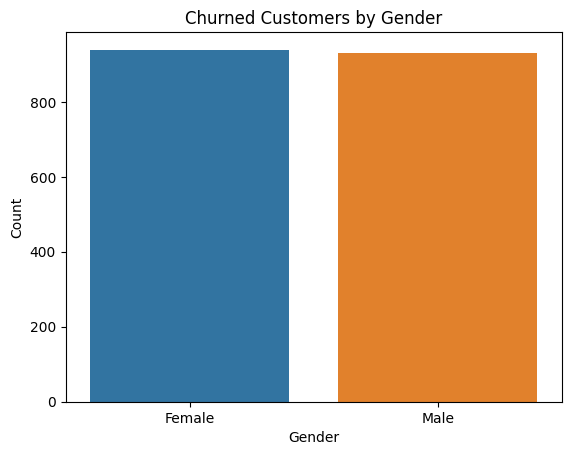

In [117]:
sns.barplot(x=churned_count_by_gender.index, y=churned_count_by_gender.values)
plt.title('Churned Customers by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

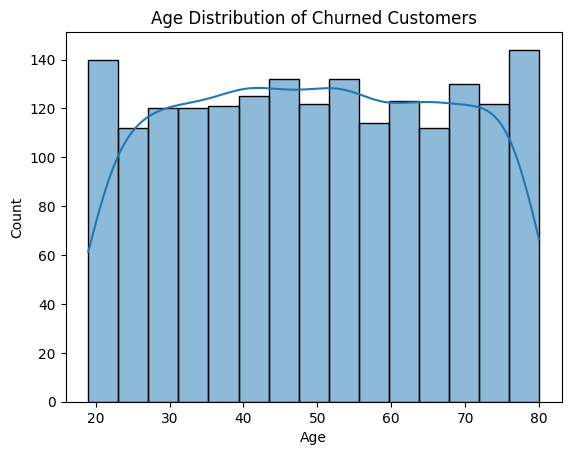

In [118]:
sns.histplot(data=churned_customers, x='Age', bins=15, kde=True)
plt.title('Age Distribution of Churned Customers')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [74]:
churned_counts = data[data['Churn'] == 1]['Gender'].value_counts()
non_churned_counts = data[data['Churn'] == 0]['Gender'].value_counts()

In [75]:
labels = churned_counts.index
churned_percentages = churned_counts / churned_counts.sum() * 100
non_churned_percentages = non_churned_counts / non_churned_counts.sum() * 100

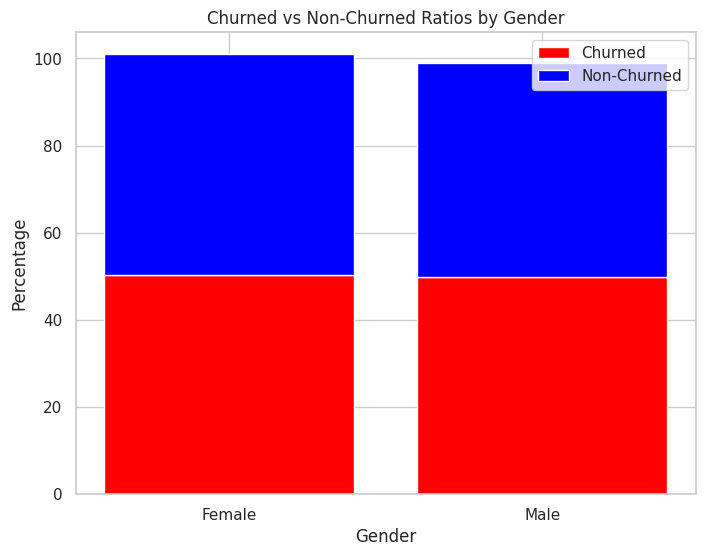

In [125]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(labels, churned_percentages, label='Churned', color='red')
ax.bar(labels, non_churned_percentages, bottom=churned_percentages, label='Non-Churned', color='blue')
ax.set_title('Churned vs Non-Churned Ratios by Gender')
ax.set_xlabel('Gender')
ax.set_ylabel('Percentage')
ax.legend()
plt.show()

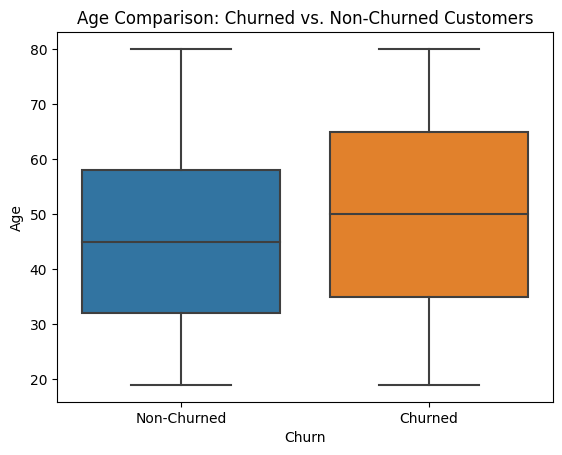

In [77]:
sns.boxplot(data=data, x='Churn', y='Age')
plt.title('Age Comparison: Churned vs. Non-Churned Customers')
plt.xlabel('Churn')
plt.ylabel('Age')
plt.xticks([0, 1], ['Non-Churned', 'Churned'])
plt.show()

**Analyzing Monthly Charges**

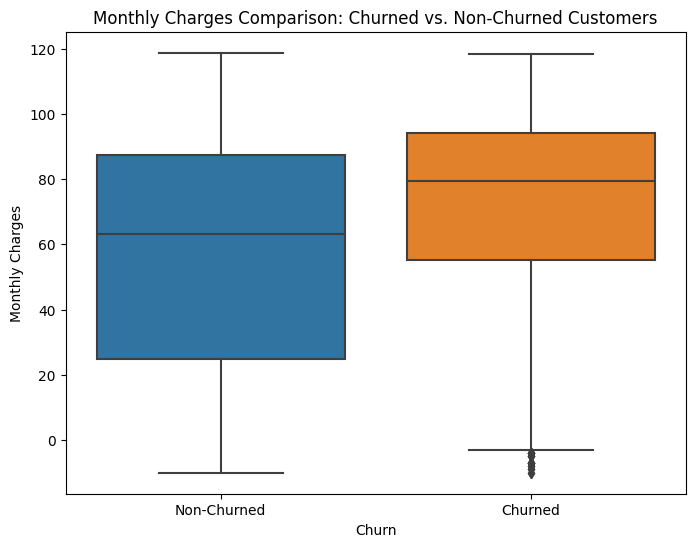

In [78]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='Churn', y='Monthly Charges')
plt.title('Monthly Charges Comparison: Churned vs. Non-Churned Customers')
plt.xlabel('Churn')
plt.ylabel('Monthly Charges')
plt.xticks([0, 1], ['Non-Churned', 'Churned'])
plt.show()

**Analyzing Churn Rate by Pricing Tiers**

In [83]:
pricing_tiers = pd.qcut(data['Monthly Charges'], q=5)
churn_rates = data.groupby(pricing_tiers)['Churn'].mean()
average_churn_rate = data['Churn'].mean()

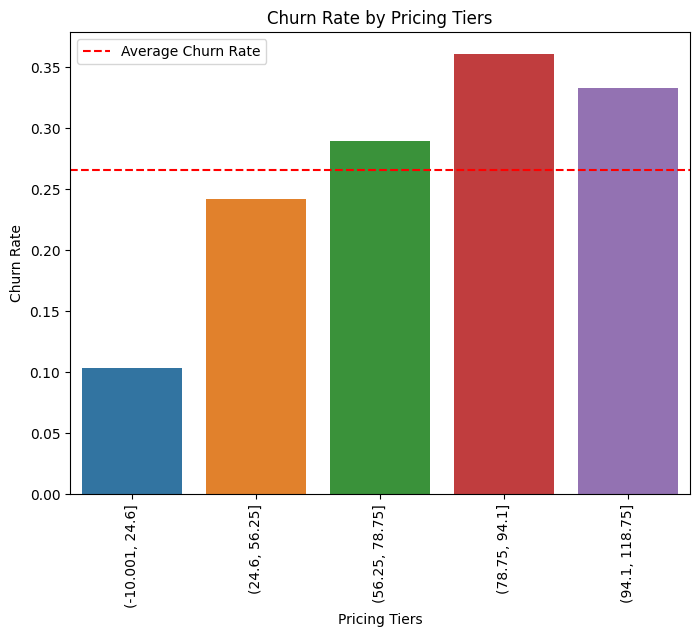

In [85]:
plt.figure(figsize=(8, 6))
sns.barplot(x=churn_rates.index, y=churn_rates.values)
plt.axhline(average_churn_rate, color='red', linestyle='--', label='Average Churn Rate')
plt.xlabel('Pricing Tiers')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Pricing Tiers')
plt.legend()
plt.xticks(rotation='vertical')
plt.show()

**Analyzing Churn Rate by Tenure Segments**

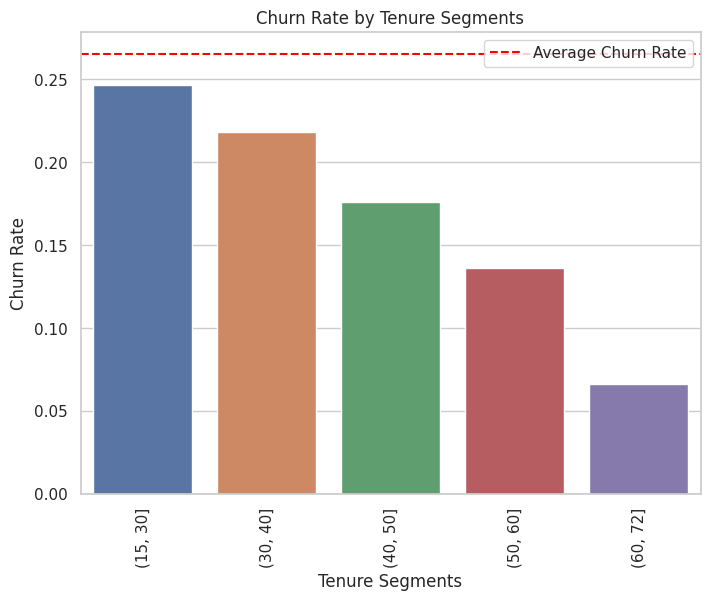

In [128]:
tenure_segments = pd.cut(data['Tenure'], bins=[15, 30, 40, 50, 60, 72])
churn_rates = data.groupby(tenure_segments)['Churn'].mean().reset_index()
average_churn_rate = data['Churn'].mean()
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(x=tenure_segments.cat.categories, y='Churn', data=churn_rates)
plt.axhline(average_churn_rate, color='red', linestyle='--', label='Average Churn Rate')
plt.xlabel('Tenure Segments')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Tenure Segments')
plt.legend()
plt.xticks(rotation='vertical')
plt.show()

**Analyzing Churn Reasons**

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Most common reasons for churn:
- competitor: 841 mentions
- service: 223 mentions
- price: 78 mentions


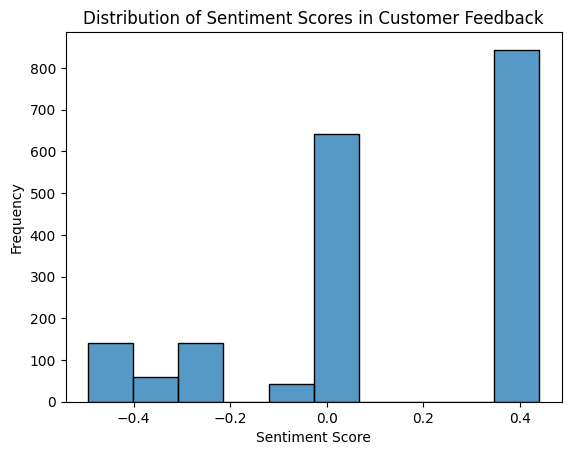

In [88]:
import nltk
nltk.download('vader_lexicon')

churned_data = data[data['Churn'] == 1]

churned_data['Churn Reason'] = churned_data['Churn Reason'].str.lower().str.replace('[^\w\s]', '')

reasons = ['price', 'service', 'customer support', 'competitor', 'other']
reason_counts = {reason: 0 for reason in reasons}

for feedback in churned_data['Churn Reason']:
    for reason in reasons:
        if reason in feedback:
            reason_counts[reason] += 1

sia = SentimentIntensityAnalyzer()
churned_data['Sentiment'] = churned_data['Churn Reason'].apply(lambda x: sia.polarity_scores(x)['compound'])

most_common_reasons = sorted(reason_counts.items(), key=lambda x: x[1], reverse=True)[:3]

print("Most common reasons for churn:")
for reason, count in most_common_reasons:
    print(f"- {reason}: {count} mentions")

sns.histplot(data=churned_data['Sentiment'], bins=10)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores in Customer Feedback')
plt.show()

**Customer Segmentation**

In [130]:
selected_features = ['Monthly Charges', 'Total Charges', 'Age', 'Tenure']
model_data = data[selected_features + ['Churn']]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(model_data[selected_features])

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(scaled_data)

model_data['Cluster'] = kmeans.labels_

segment_characteristics = model_data.groupby('Cluster').mean()

print("Segment Characteristics:")
print(segment_characteristics)

churn_rates = model_data.groupby('Cluster')['Churn'].mean()

print("Churn Rates by Segment:")
print(churn_rates)

Segment Characteristics:
         Monthly Charges  Total Charges        Age     Tenure     Churn
Cluster                                                                
0              26.095021     299.735436  41.914246  10.971646  0.220609
1              76.525741    1259.726692  32.139163  16.295057  0.415970
2              93.634339    5675.853075  47.708428  60.652620  0.146925
3              76.142565    1324.955355  64.663711  17.205321  0.476808
4              31.599906    1944.891179  43.513208  55.733962  0.043396
Churn Rates by Segment:
Cluster
0    0.220609
1    0.415970
2    0.146925
3    0.476808
4    0.043396
Name: Churn, dtype: float64


**Predictive Modeling**

Accuracy: 0.7892122072391767
Precision: 0.6407407407407407
Recall: 0.46380697050938335
F1 Score: 0.5381026438569206


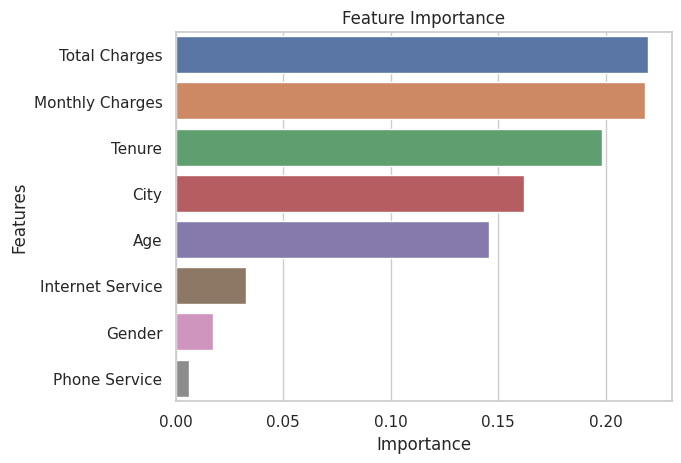

In [131]:
categorical_cols = ['Gender', 'City', 'Internet Service', 'Phone Service']
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

X = data.drop(['Churn', 'Churn Reason'], axis=1)
y = data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

### **SUMMARY**

1.   **Overall Churn rate for the company**: The telecom company has a churn rate of 26.54%, indicating that approximately 26.54% of customers have discontinued their service.

2.   **Gender-based churn rate**: Female customers have a slightly higher churn rate of 50.24% compared to male customers with a churn rate of 49.76%.

3.   **Age distribution**: Half of the churned customers fall within the age range of 35 to 65, indicating that churn is not limited to specific age groups.

4.   **Tenure distribution**: The majority of churned customers have been using the service for 15 to 40 months, suggesting that customers who have been with the company for a moderate period are more likely to churn.

5.   **Charges and churn**: Churned customers tend to have higher monthly charges compared to customers who remained with the company. This suggests that higher charges may contribute to customer dissatisfaction and increase the likelihood of churn.

6.   **Impact of monthly charges**: Customers with monthly charges above 57 are more prone to churn, indicating a pricing threshold beyond which customers become more sensitive to churn.

7.   **Common reasons for churn**: The analysis identifies common reasons for churn, including competitor offers, service quality, and pricing. Addressing these areas can help reduce churn.

8.   **Key factors impacting churn**: The predictive modeling reveals that charges, tenure, location, and age are the key factors influencing churn rate. These variables play a significant role in predicting customer churn.

Conclusion : These findings provide valuable insights into the telecom churn behavior and suggest strategies such as optimizing pricing plans, improving service quality, and addressing competitor offerings to reduce churn and enhance customer retention.

